In [1]:
from lib.datasets import ATPBind3D

from torchdrug import transforms
from torchdrug import data, core, layers, tasks, metrics, utils, models
from torchdrug.layers import functional
from torchdrug.core import Registry as R

import torch
from torch.utils import data as torch_data
from torch.nn import functional as F
from lib.tasks import NodePropertyPrediction


In [23]:
truncuate_transform = transforms.TruncateProtein(max_length=350, random=False)
protein_view_transform = transforms.ProteinView(view='residue')
transform = transforms.Compose([truncuate_transform, protein_view_transform])

dataset = ATPBind3D(transform=transform)

train_set, valid_set, test_set = dataset.split()
print("train samples: %d, valid samples: %d, test samples: %d" %
      (len(train_set), len(valid_set), len(test_set)))


Split num:  [337, 41, 41]
train samples: 337, valid samples: 41, test samples: 41


In [24]:
from torchdrug import core, layers
from torchdrug.layers import geometry
import torch
from lib.tasks import NodePropertyPrediction

graph_construction_model = layers.GraphConstruction(node_layers=[geometry.AlphaCarbonNode()],
                                                    edge_layers=[geometry.SpatialEdge(radius=10.0, min_distance=5),
                                                                 geometry.KNNEdge(
                                                                     k=10, min_distance=5),
                                                                 geometry.SequentialEdge(max_distance=2)],
                                                    edge_feature="gearnet")
task = NodePropertyPrediction(
    models.GearNet(input_dim=21, hidden_dims=[512, 512, 512, 512, 512, 512], num_relation=7,
                   edge_input_dim=59, num_angle_bin=8,
                   batch_norm=True, concat_hidden=True, short_cut=True, readout="sum").cuda(),
    graph_construction_model=graph_construction_model,
    normalization=False,
    num_mlp_layer=2,
    metric=("micro_auroc", "mcc")
)

optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1)


22:03:09   Preprocess training set
22:03:10   {'batch_size': 1,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'class': 'optim.Adam',
               'eps': 1e-08,
               'lr': 0.0001,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'NodePropertyPrediction',
          'criterion': 'bce',
          'graph_construction_model': {'class': 'layers.GraphConstruction',
                                       'edge_feature': 'gearnet',
                                       'edge_layers': [SpatialEdge(),
                                                       KNNEdge(),
                                                       SequentialEdge()],
                                       'node_layers': [AlphaCarbonNode()]},
          'metric': ('micro_auroc', 'mcc'),
          'model': {'activation': 'relu',

In [26]:

metrics = []



In [27]:
for i in range(10):
    solver.train(num_epoch=1)
    metrics.append(solver.evaluate("test"))

22:04:58   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:04:58   Epoch 0 begin
22:05:02   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:05:02   binary cross entropy: 0.167307
22:05:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:05:21   binary cross entropy: 0.168641
22:05:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:05:39   binary cross entropy: 0.0790259
22:05:59   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:05:59   binary cross entropy: 0.0585148
22:06:02   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:06:02   Epoch 0 end
22:06:02   duration: 2.87 mins
22:06:02   speed: 2.41 batch / sec
22:06:02   ETA: 0.00 secs
22:06:02   max GPU memory: 1942.1 MiB
22:06:02   ------------------------------
22:06:02   average binary cross entropy: 0.172433
22:06:02   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:06:02   Evaluate on test
22:06:06   ------------------------------
22:06:06   mcc: 0.283902
22:06:06   micro_auroc: 0.792017
22:06:06   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:06:06   Epoch 1 begin
22:06:21   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:06:21   binary cross entro

In [28]:
solver.evaluate("train")

22:16:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:16:39   Evaluate on train
22:17:13   ------------------------------
22:17:13   average mcc: 0.892702
22:17:13   average micro_auroc: 0.99582


{'micro_auroc': tensor(0.9958, device='cuda:0'), 'mcc': 0.8927023993279446}

In [29]:
for i in range(10):
    solver.train(num_epoch=1)
    metrics.append(solver.evaluate("test"))

22:17:25   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:17:25   Epoch 10 begin
22:17:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:17:34   binary cross entropy: 0.00054836
22:17:54   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:17:54   binary cross entropy: 0.0108134
22:18:13   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:13   binary cross entropy: 0.0069298
22:18:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:29   Epoch 10 end
22:18:29   duration: 2.57 mins
22:18:29   speed: 2.19 batch / sec
22:18:29   ETA: 0.00 secs
22:18:29   max GPU memory: 1584.7 MiB
22:18:29   ------------------------------
22:18:29   average binary cross entropy: 0.0064856
22:18:29   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:29   Evaluate on test
22:18:34   ------------------------------
22:18:34   mcc: 0.418694
22:18:34   micro_auroc: 0.862347
22:18:34   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:34   Epoch 11 begin
22:18:36   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:36   binary cross entropy: 0.119028
22:18:54   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:18:54   binary cross

In [30]:
metrics

[{'micro_auroc': tensor(0.7920, device='cuda:0'), 'mcc': 0.28390220252630066},
 {'micro_auroc': tensor(0.8260, device='cuda:0'), 'mcc': 0.36470653522273005},
 {'micro_auroc': tensor(0.8283, device='cuda:0'), 'mcc': 0.38201917031405924},
 {'micro_auroc': tensor(0.8467, device='cuda:0'), 'mcc': 0.3929330169276621},
 {'micro_auroc': tensor(0.8480, device='cuda:0'), 'mcc': 0.37539509774225155},
 {'micro_auroc': tensor(0.8090, device='cuda:0'), 'mcc': 0.3393135189053216},
 {'micro_auroc': tensor(0.8517, device='cuda:0'), 'mcc': 0.4024545450274999},
 {'micro_auroc': tensor(0.8234, device='cuda:0'), 'mcc': 0.3690310303262522},
 {'micro_auroc': tensor(0.8584, device='cuda:0'), 'mcc': 0.4482661107624361},
 {'micro_auroc': tensor(0.8654, device='cuda:0'), 'mcc': 0.4489951431010275},
 {'micro_auroc': tensor(0.8623, device='cuda:0'), 'mcc': 0.41869430684716674},
 {'micro_auroc': tensor(0.8218, device='cuda:0'), 'mcc': 0.39213858932746376},
 {'micro_auroc': tensor(0.8741, device='cuda:0'), 'mcc': 0

In [32]:
for i in range(30):
    solver.train(num_epoch=1)
    metrics.append(solver.evaluate("test"))

22:32:56   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:32:56   Epoch 20 begin
22:33:13   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:33:13   binary cross entropy: 0.000190405
22:33:33   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:33:33   binary cross entropy: 0.000113846
22:33:53   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:33:53   binary cross entropy: 0.000366866
22:34:04   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:34:04   Epoch 20 end
22:34:04   duration: 5.62 mins
22:34:04   speed: 1.00 batch / sec
22:34:04   ETA: 0.00 secs
22:34:04   max GPU memory: 1584.7 MiB
22:34:04   ------------------------------
22:34:04   average binary cross entropy: 0.00345013
22:34:04   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:34:04   Evaluate on test
22:34:09   ------------------------------
22:34:09   mcc: 0.403091
22:34:09   micro_auroc: 0.861054
22:34:09   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:34:09   Epoch 21 begin
22:34:18   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:34:18   binary cross entropy: 0.00695513
22:34:39   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
22:34:39   bina

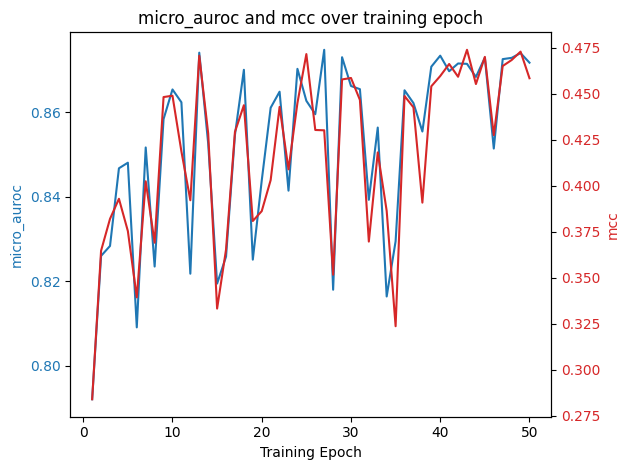

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline


# metrics is your list of dictionaries
micro_auroc = [float(m['micro_auroc'].cpu().numpy())
               for m in metrics]  # convert tensors to floats
mcc = [m['mcc'] for m in metrics]

# Create x values, which are simply the index of each measurement
x_values = list(range(1, len(micro_auroc)+1))

# Create a new figure and add two subplots: one for each metric
fig, ax1 = plt.subplots()

# Plot the micro_auroc values in blue on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('micro_auroc', color=color)
ax1.plot(x_values, micro_auroc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the mcc values
ax2 = ax1.twinx()

# Plot the mcc values in red on the right y-axis
color = 'tab:red'
ax2.set_ylabel('mcc', color=color)
ax2.plot(x_values, mcc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('micro_auroc and mcc over training epoch')
fig.tight_layout()
plt.show()
